In [1]:
import argparse
from lib2to3.pgen2 import token
import logging
import os
import random
from dataclasses import dataclass
from itertools import chain
from typing import Optional, Union
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import datasets
import torch
from torch.nn.modules.sparse import Embedding
import torch.nn as nn
from torch.nn.modules.linear import Linear
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from train import DataCollatorForMultipleChoice

import transformers
from accelerate import Accelerator
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    PreTrainedTokenizerBase,
    default_data_collator,
    DataCollatorForSeq2Seq,
    AdamW,
    SchedulerType,
    get_scheduler,
    set_seed,
)
from transformers.file_utils import PaddingStrategy

logger = logging.getLogger(__name__)


/opt/conda/envs/tz/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = {}
args["dataset_name"] = "miniprompts002.parquet.gzip"
args["eval_name"] = "miniprompts002_eval.parquet.gzip"
args["model_name_or_path"] = "bigscience/T0_3B"
args["output_dir"] = "/home/gikok/output"
args["num_train_epochs"] = 1
args["per_device_train_batch_size"] = 16
args["per_device_eval_batch_size"] = 16
args["freeze_encoder"] = True
args["learning_rate"] = 1e30
args["parallelize"] = False
args["seed"] = 42
args["pad_to_max_length"] = False
args["input_eos"] = False
args["target_max_length"] = 256
args["max_length"] = 512
args["num_warmup_steps"] = 0
args["debug"] = False
args["lr_scheduler_type"] = "linear"
args["num_shots"] = None
args["weight_decay"] = 0.0
args["gradient_checkpoint"] = False
args["gradient_accumulation_steps"] = 1
args["max_train_steps"] = None


def resample(model, layer, n_new):

    new_tensor = list(model.named_parameters())[layer][1].detach().cpu()

    for i in range(2048):
        val, bin = np.histogram(new_tensor[:-n_new, i], 10000)
        pdf = val / sum(val)
        cdf = np.cumsum(pdf)
        b = (bin[1:] + bin[:-1]) / 2
        new_tensor[-n_new:, i] = torch.tensor(
            np.interp(np.random.random(n_new), cdf, b)
        )
    data = list(model.named_parameters())[layer][1].data
    data[:, :] = new_tensor


In [3]:
set_seed(args["seed"])

# Initialize the accelerator. We will let the accelerator handle device placement for us.
accelerator = Accelerator()
# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state)

# Setup logging, we only want one process per machine to log things on the screen.
# accelerator.is_local_main_process is only True for one process per machine.
logger.setLevel(logging.INFO if accelerator.is_local_main_process else logging.ERROR)
if accelerator.is_local_main_process:
    datasets.utils.logging.set_verbosity_warning()
    transformers.utils.logging.set_verbosity_info()
else:
    datasets.utils.logging.set_verbosity_error()
    transformers.utils.logging.set_verbosity_error()

# Handle the output directory creation
if accelerator.is_main_process:
    os.makedirs(args["output_dir"], exist_ok=True)
accelerator.wait_for_everyone()

# In distributed evaluation, the load_dataset function guarantee that only one local process can concurrently
# download the dataset.
if args["dataset_name"] is not None:
    data_files = {"train": args["dataset_name"], "test": args["eval_name"]}
    raw_train_dataset = load_dataset("data", data_files=data_files, split="train")
    raw_eval_dataset = load_dataset("data", data_files=data_files, split="test")

else:
    raise ValueError("Please specify `args['dataset_name`.")

# Trim a number of evaluation training
if args["debug"]:
    raw_train_dataset = raw_train_dataset.select(
        range(min(100, len(raw_train_dataset)))
    )


model = AutoModelForSeq2SeqLM.from_pretrained(args["model_name_or_path"]).to("cuda:0")
tokenizer = AutoTokenizer.from_pretrained(args["model_name_or_path"])

# get all item_no and add as tokens
items = pd.read_parquet("data/item_no_100.parquet.gzip")["item_no"].values.tolist()
# tokenizer.add_tokens(items)

# # then resize embeddings
# model.resize_token_embeddings(len(tokenizer))

# # resample shared embedding and lm_head layer
# resample(model, 0, len(items))
# resample(model, -1, len(items))


# Preprocessing the datasets.
# First we tokenize all the texts.
padding = "max_length" if args["pad_to_max_length"] else False


def tokenize_train(examples):
    input_texts = examples["input"]
    target_texts = examples["target"]

    model_inputs = tokenizer(
        input_texts,
        padding=padding,
        max_length=args["max_length"],
        truncation=True,
        add_special_tokens=args["input_eos"],
    )

    with tokenizer.as_target_tokenizer():
        tokenized_targets = tokenizer(
            target_texts,
            padding=padding,
            max_length=args["target_max_length"],
            truncation=True,
            add_special_tokens=False,
        )
        model_inputs["labels"] = [
            [(t if t != tokenizer.pad_token_id else -100) for t in targets]
            for targets in tokenized_targets["input_ids"]
        ]
    return model_inputs


column_names = raw_eval_dataset.column_names


def preprocess_eval(examples):
    input_texts = examples["input"]
    target_texts = examples["target"]
    answer_choices_texts = examples["options"]
    bs = len(examples[column_names[0]])

    tokenized_inputs = tokenizer(
        input_texts,
        padding=padding,
        max_length=args["max_length"],
        truncation=True,
        add_special_tokens=False,
    )
    tokenized_targets = [
        tokenizer(
            ans_choi,
            padding=padding,
            max_length=args["target_max_length"],
            truncation=True,
        )
        for ans_choi in answer_choices_texts
    ]

    features = {
        k: [
            [elem for _ in range(len(tokenized_targets[idx]["input_ids"]))]
            for idx, elem in enumerate(v)
        ]
        for k, v in tokenized_inputs.items()
    }

    features["labels"] = [tokenized_targets[idx]["input_ids"] for idx in range(bs)]
    features["labels_attention_mask"] = [
        tokenized_targets[idx]["attention_mask"] for idx in range(bs)
    ]
    features["targets"] = [
        answer_choices_texts[idx].index(t) for idx, t in enumerate(target_texts)
    ]

    return features


with accelerator.main_process_first():
    eval_dataset = raw_eval_dataset.map(
        preprocess_eval, batched=True, remove_columns=column_names
    )

    if args["num_shots"] is not None:
        sample_indices = random.sample(
            range(0, len(raw_train_dataset)), k=args["num_shots"]
        )
        raw_train_dataset = raw_train_dataset.select(sample_indices)
    train_dataset = raw_train_dataset.map(tokenize_train, batched=True)
    train_dataset.set_format(
        type="torch", columns=["input_ids", "attention_mask", "labels"]
    )


# Log a few random training:
for index in random.sample(range(len(train_dataset)), 3):
    logger.debug(f"Sample {index} of the training set: {train_dataset[index]}.")
# for index in random.sample(range(len(eval_dataset)), 3):
#     logger.debug(f"Sample {index} of the evaluation set: {eval_dataset[index]}.")

# DataLoaders creation:
train_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=-100,
    pad_to_multiple_of=8 if accelerator.use_fp16 else None,
)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=train_collator,
    batch_size=args["per_device_train_batch_size"],
)

if args["pad_to_max_length"]:
    # If padding was already done ot max length, we use the default data collator that will just convert everything
    # to tensors.
    eval_collator = default_data_collator
else:
    # Otherwise, `DataCollatorWithPadding` will apply dynamic padding for us (by padding to the maximum length of
    # the samples passed). When using mixed precision, we add `pad_to_multiple_of=8` to pad all tensors to multiple
    # of 8s, which will enable the use of Tensor Cores on NVIDIA hardware with compute capability >= 7.5 (Volta).
    eval_collator = DataCollatorForMultipleChoice(
        tokenizer, pad_to_multiple_of=(8 if accelerator.use_fp16 else None)
    )
eval_dataloader = DataLoader(
    eval_dataset,
    collate_fn=eval_collator,
    batch_size=args["per_device_eval_batch_size"],
)

# Optimizer
# Split weights in two groups, one with weight decay and the other not.
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": args["weight_decay"],
    },
    {
        "params": [
            p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=args["learning_rate"])

# Scheduler and math around the number of training steps.
num_update_steps_per_epoch = math.ceil(
    len(train_dataloader) / args["gradient_accumulation_steps"]
)
if args["max_train_steps"] is None:
    args["max_train_steps"] = args["num_train_epochs"] * num_update_steps_per_epoch
else:
    args["num_train_epochs"] = math.ceil(
        args["max_train_steps"] / num_update_steps_per_epoch
    )

lr_scheduler = get_scheduler(
    name=args["lr_scheduler_type"],
    optimizer=optimizer,
    num_warmup_steps=args["num_warmup_steps"],
    num_training_steps=args["max_train_steps"],
)

if args["parallelize"]:
    num_gpus = torch.cuda.device_count()
    assert num_gpus > 1, "You need at least 2 GPUs to use `model.parallelize()`."
    model.parallelize()
    optimizer, train_dataloader = accelerator.prepare(optimizer, train_dataloader)
else:
    model, optimizer, train_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader
    )

# Metrics
metric = load_metric("accuracy")

total_batch_size = (
    args["per_device_train_batch_size"]
    * accelerator.num_processes
    * args["gradient_accumulation_steps"]
)
logger.info("***** Running training *****")
logger.info(f"  Num training = {len(train_dataset)}")
logger.info(f"  Num Epochs = {args['num_train_epochs']}")
logger.info(
    f"  Instantaneous batch size per device = {args['per_device_train_batch_size']}"
)
logger.info(
    f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}"
)
logger.info(f"  Gradient Accumulation steps = {args['gradient_accumulation_steps']}")
logger.info(f"  Total optimization steps = {args['max_train_steps']}")
# Only show the progress bar once on each machine.
progress_bar = tqdm(
    range(args["max_train_steps"]), disable=not accelerator.is_local_main_process
)
global_steps = 0

# how often trained model should be saved
r = int(args["max_train_steps"] / 30)
if args["gradient_checkpoint"]:
    model.gradient_checkpointing_enable()
model_counter = 0


10/18/2022 16:53:20 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

10/18/2022 16:53:20 - WARNING - datasets.builder - Using custom data configuration data-11314387c41b991e
10/18/2022 16:53:20 - WARNING - datasets.builder - Reusing dataset parquet (/home/gikok/.cache/huggingface/datasets/parquet/data-11314387c41b991e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
10/18/2022 16:53:20 - WARNING - datasets.builder - Using custom data configuration data-11314387c41b991e
10/18/2022 16:53:20 - WARNING - datasets.builder - Reusing dataset parquet (/home/gikok/.cache/huggingface/datasets/parquet/data-11314387c41b991e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
loading configuration file https://huggingface.co/bigscience/T0_3B/resolve/main/config.json from cache at /home/gikok/.cache/huggingface/transformers/7b128e6b48089ae556964fea17b39635abd0124e77f8fa30267896af500a4d6d.

In [ ]:
em_grad = []
em_delta_pct = []
lm_grad = []
lm_delta_pct = []
em = list(model.named_parameters())[0][1]
lm = list(model.named_parameters())[-1][1]
em_old = em * 1
lm_old = lm * 1
init_len = len(tokenizer) - len(items)
def hook(grad):
    grad_mask[:init_len, :] = 0
    return grad*grad_mask
for name, param in model.named_parameters():
    if name.startswith("encoder") or name.startswith("decoder"):
        param.requires_grad = False
    if name.startswith("shared") or name.startswith("lm_head"):
        grad_mask = torch.ones_like(param)
        grad_mask[:init_len, :] = 0
        h = param.register_hook(hook)
for epoch in range(1, 2):#args["num_train_epochs"] + 1):
    model.train()

    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        if step % 1 == 0 or step == len(train_dataloader) - 1:
            item_no = int(step/4)
            ind = len(tokenizer) - 100 + item_no
            em_grad += [
                ((em.grad[ind, :]).mean()).cpu()*1
            ]
            lm_grad += [
                ((lm.grad[ind, :]).mean()).cpu()*1
            ]
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            loss = loss.item()
            em = list(model.named_parameters())[0][1]
            lm = list(model.named_parameters())[-1][1]
            em_delta_pct += [
                (((em[ind, :] - em_old[ind, :]) / em[ind, :]).mean()).cpu()
            ]
            lm_delta_pct += [
                (((lm[ind, :] - lm_old[ind, :]) / lm[ind, :]).mean()).cpu()
            ]
            em_old = em * 1
            lm_old = lm * 1
            if accelerator.is_main_process:
                tqdm.write(f"epoch = {epoch}, step = {global_steps}, loss = {loss}")
        if step >= 25:
            break


In [4]:
init_len = len(tokenizer) - len(items)
def hook(grad):
    grad_mask[:init_len, :] = 0
    return grad*grad_mask
for name, param in model.named_parameters():
    if name.startswith("encoder") or name.startswith("decoder"):
        param.requires_grad = False
    if name.startswith("shared") or name.startswith("lm_head"):
        grad_mask = torch.ones_like(param)
        grad_mask[:init_len, :] = 0
        h = param.register_hook(hook)

In [5]:
lm = list(model.named_parameters())[-1][1]
lm[0]

tensor([-0.0476074218750000, -0.0622558593750000, -0.0976562500000000,
         ...,  0.0262451171875000,  0.0427246093750000,
        -0.0295410156250000], device='cuda:0', grad_fn=<SelectBackward>)

In [6]:
lm = list(model.named_parameters())[-1][1]
lm[0]

tensor([-0.0476074218750000, -0.0622558593750000, -0.0976562500000000,
         ...,  0.0262451171875000,  0.0427246093750000,
        -0.0295410156250000], device='cuda:0', grad_fn=<SelectBackward>)

In [7]:
import pytorch_lightning as pl


In [8]:
# define the LightningModule
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.learning_rate = lr

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        outputs = model(**batch)
        loss = outputs.loss
        # Logging to TensorBoard by default
        print(loss)
        #self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.learning_rate)

        return optimizer

In [9]:
plmodel = LitAutoEncoder(model)

In [16]:
trainer = pl.Trainer(accelerator="gpu", devices=1, auto_select_gpus=True, auto_lr_find=True, accumulate_grad_batches=16)

10/18/2022 16:59:35 - INFO - pytorch_lightning.trainer.connectors.accelerator_connector - Auto select gpus: [0]
10/18/2022 16:59:36 - INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True
10/18/2022 16:59:36 - INFO - pytorch_lightning.utilities.rank_zero - TPU available: False, using: 0 TPU cores
10/18/2022 16:59:36 - INFO - pytorch_lightning.utilities.rank_zero - IPU available: False, using: 0 IPUs
10/18/2022 16:59:36 - INFO - pytorch_lightning.utilities.rank_zero - HPU available: False, using: 0 HPUs


In [17]:
#trainer.fit(model=plmodel, train_dataloaders=train_dataloader)
lr_finder = trainer.tuner.lr_find(model=plmodel, train_dataloaders=train_dataloader)


4.786300923226385e-05


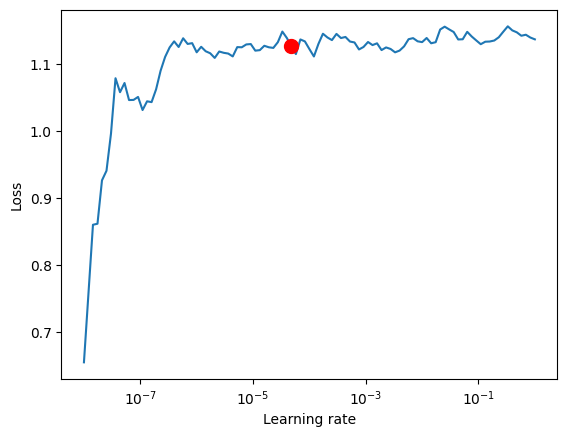

In [ ]:
fig = lr_finder.plot(suggest=True)
print(lr_finder.suggestion())
fig.show()

In [ ]:
model.train()
for name, param in model.named_parameters():
    if name.startswith("encoder") or name.startswith("decoder"):
        param.requires_grad = False
    if name.startswith("shared") or name.startswith("lm_head"):
        t = torch.zeros(param.shape).to("cuda:0")
        t[-len(items) :, :] = 1
        param.register_hook(lambda grad: grad * t)
outputs = model(**batch)
loss = outputs.loss
accelerator.backward(loss)
optimizer.step()
lr_scheduler.step()
optimizer.zero_grad()
progress_bar.update(1)
global_steps += 1
loss = loss.item()
if accelerator.is_main_process:
    tqdm.write(f"epoch = {1}, step = {global_steps}, loss = {loss}")


In [ ]:
last(model.children())


In [ ]:
old_values[0][1].grad


In [ ]:
t = torch.tensor(np.zeros((new_values[0][1].shape[0], new_values[0][1].shape[1])))


In [ ]:
t[-len(items) :, :] = 1


In [11]:
torch.cuda.empty_cache()

In [ ]:
l = 0
for mod in model.modules():
    l += 1
    if isinstance(mod, Embedding):
        if mod.num_embeddings == 38136:
            print(l, mod)
            print(type(mod))
            print(mod.num_embeddings)
            print("****************")


In [ ]:
l = 0
for mod in model.modules():
    print(mod)
    print("**************")
